# **Insurance cost Prediction**

Accurate prediction of healthcare costs is important for optimally managing health costs. In this project, we connected historical data of customer behavior, health history and demographics to estimate the amount of medical insurance charges they are likely going to pay.

The dataset used was the Medical Insurance Kaggle dataset (insurance.csv) consisting of the following colunms; Age: Age of primary beneficiary, Sex: Primary beneficiary’s gender, BMI: Body mass index (providing an understanding of the body, weights that are relatively high or low relative to height), Children: Number of children covered by health insurance / Number of dependents, Smoker: Smoking (yes, no), Region: Beneficiary’s residential area in the US (northeast, southeast, southwest, northwest), Charges: Individual medical costs billed by health insurance.

This project involved three main stages. First, we created a database to stored the downloded dataset form kaggle. Using the stored dataset, we traing a model to predict the value of the insurance charges based on the other features. Finally, we created an interactive dashboard to visualize the data. 


## **Duilding a Database**

In building the database, we used SQLITE3. The datadase was created from the insuranve.csv dataset.

In [1]:
#importing the libraries
import sqlite3
import pandas as pd

### Creating a Table

In [2]:
# creating a database with sqlite3
con = sqlite3.connect('my_data.db') #the database my_data.db created on my local machine
cur = con.cursor()

In [3]:
# load the data into a Pandas DataFrame
insurance = pd.read_csv('insurance.csv')

# write the data to a sqlite table
insurance.to_sql('insurance', con, if_exists='replace', index = False) 
''' Write records stored in a DataFrame to a SQL database. '''

' Write records stored in a DataFrame to a SQL database. '

In [4]:
con.commit()
cur.close()
con.close()

### fetch some Data from the database 

In [5]:
con = sqlite3.connect('my_data.db')
cur = con.cursor()

data = pd.read_sql('''SELECT * FROM insurance''', con)
data
#cmd = '''SELECT * FROM insurance'''
#cur.execute(cmd)
#ret = cur.fetchall()
#''' The fetchall() method returns an array of tuples. '''
#ret

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Regression model with insurance data

In this section, we developed a deep neural network to predict cost from health insurance claims records.This model intend to predict the value of the insurance cover charges based on factors like age, sex, number of children among others. We used the data obtained from the datadase in the pevious section. The data was earlier stored in a padandas dataframe data. 

The original data had 1338 rows, and 7 main colunms. When duplicates were droped, there were 1337 rows. No missing values were found in the data.

From the plots, a general trend of the insurance charges increses with increase in Age is visible.


In [6]:
#importing libraries
import keras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from tensorflow.keras.losses import MeanSquaredError

2022-03-14 08:39:12.207341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-14 08:39:12.207407: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### EDA

In [7]:
#looking into the data
data.head(5) #data = pd.read_csv('insurance.csv')

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
#number if row in the dataset
data.shape

#there are 1337 rows in the dataset

(1338, 7)

In [7]:
#cheaking for duplicate values
data.drop_duplicates(inplace = True)
data.shape

# there was one duplicate value in data
#the remaing data has 1337 rows

(1337, 7)

In [10]:
#cheaking for nall values
data.isna().sum()

#the data has no null values

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### Statistical overview

In [11]:
#the statistical view of the data
data.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
#cheaking for the information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


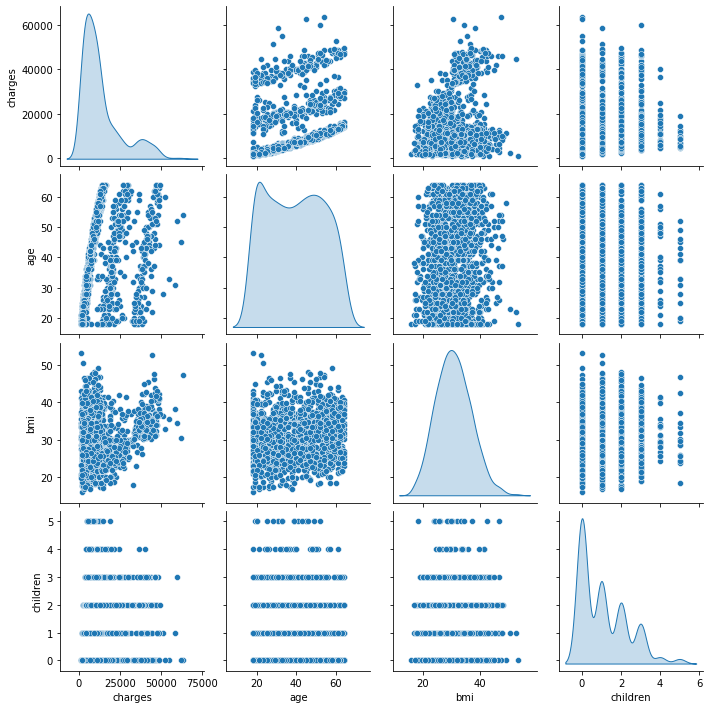

In [12]:
sns.pairplot(data[['charges', 'age', 'bmi', 'children']], diag_kind='kde')

### Preparing the data for trainig

Since the colunms sex, smoker and region are categorical values, we encoded them using the get_dummies function. We splited the data into traing and testing datasets. We trained our model on the training dataset and the test dataset was used to evaluate the model(Predict ‘y’ variable). The features and lables to be used for model training were obtained. The test_size contained 20% of the data and the rest was utilized as the training set.

In [8]:
#one_hot encode categorrical values
df_data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], prefix='', prefix_sep='')
'''
Convert categorical variable into dummy/indicator variables.


Parameters
-----------

    data: array-like, Series, or DataFrame : 
         Data of which to get dummy indicators.
            
    prefix :str, list of str, or dict of str, default None
        String to append DataFrame column names. 
        Pass a list with length equal to the number of columns when calling get_dummies on a DataFrame. 
        Alternatively, prefix can be a dictionary mapping column names to prefixes.
    prefix_sep: str, default ‘_’
        If appending prefix, separator/delimiter to use. 
        Or pass a list or dictionary as with prefix.
        
    columns: list-like, default None
        Column names in the DataFrame to be encoded. 
        If columns is None then all the columns with object or category dtype will be converted.
        
Returns
-------

    DataFrame: Dummy-coded data.
'''
data.head()

#if the value were integers, we will use data['colunm']= data['colunm'].map({1:a, 2:b}), before hot_encoding


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [9]:
# spliting the data into traing (0.8) and validation sets(0.2)
train_data = df_data.sample(frac=0.8, random_state=0)
test_data = df_data.drop(train_data.index)


In [10]:
#check the number of records for both training dataset and testing dataset
print(len(train_data) )# 1070
print(len(test_data)) # 267
print(len(df_data)) # 1337

1070
267
1337


In [11]:
#dataset lables
train_labels = train_data['charges']
test_labels = test_data['charges']
train_labels

1248     1633.96180
610      8547.69130
393      9290.13950
503     32548.34050
198      9644.25250
           ...     
147      9877.60770
160     21348.70600
751      1906.35825
860     46113.51100
953     38998.54600
Name: charges, Length: 1070, dtype: float64

In [12]:
#make a copy of the train and test data
train_features = train_data.copy()
test_features = test_data.copy()

#data features
train_feature = train_features.drop('charges', axis=1, inplace=True)
test_feature = test_features.drop('charges', axis=1, inplace=True)
train_feature


### Normalization

Normalizing features that use different scales and ranges is a good practice. For the normalization, tf.keras.layers.Normalization was used, because of its clean and simple way of adding feature normalization into the model. 

In [13]:
# data normalization
#creating the layer
normalizer = tf.keras.layers.Normalization(axis=-1)


In [14]:
#fit the state of the preprocessing layer to the data with Normalization.adapt
normalizer.adapt(np.array(train_features))


2022-03-14 08:40:16.255548: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-14 08:40:16.255674: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-14 08:40:16.255738: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marcelina-PC): /proc/driver/nvidia/version does not exist
2022-03-14 08:40:16.256349: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[18.   39.82  0.    1.    0.    1.    0.    0.    0.    1.    0.  ]]

Normalized: [[-1.51  1.5  -0.91  1.   -1.    0.5  -0.5  -0.58 -0.56  1.62 -0.56]]


### DNN Regression Model

We trained a deep leaning model with four layers. The 'relu' activation function was used in the deep connected layers. The optimizer was Adams with a learning rate of 0.001. Callbacks and early stopping were used to aviod overfitting. The early model had three layers, the results were not diffent form those obtained in this model.

In [16]:
#model creation function
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])


  model.compile(loss= 'MeanSquaredError',#'mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

#tf.keras.losses.MeanSquaredError
#tf.keras.losses.MeanAbsoluteError

In [18]:
# model summary
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

#tf.keras.utils.plot_model(Ubiquant_model(),show_shapes=True,expand_nested=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,176
Trainable params: 9,153
Non-trainable params: 23
_____________________________________________________

In [19]:
%%time
#fitting the model with data
#include callbacks and early stoping


callbacks = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
    
history = dnn_model.fit(
    train_features,
    train_labels,
    callbacks = [callbacks,early_stop],
    validation_split=0.2,
    verbose=0, epochs=120)


CPU times: user 21.6 s, sys: 806 ms, total: 22.4 s
Wall time: 23.7 s


In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('MeanSquaredError [charges]')
  plt.legend()
  plt.grid(True)


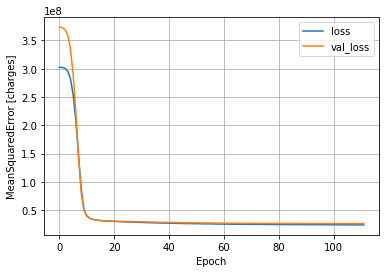

In [21]:
#ploting the loss funtion for each epoch
plot_loss(history)

Collect the results on the test set

In [22]:
#saving the test results
test_results = {}

test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [23]:
#viewing the test set perfomance
pd.DataFrame(test_results, index=['Mean absolute error [charges]']).T

,Mean absolute error [charges]
dnn_model,26841770.0


### Making predictions

Text(0, 0.5, 'Predictions [charges]')

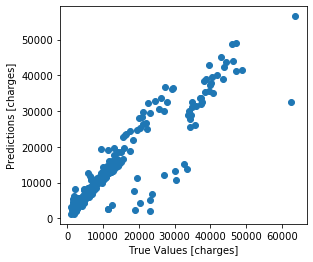

In [24]:
#making prediction of the charges with the model.predict fuction
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [charges]')
plt.ylabel('Predictions [charges]')
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)


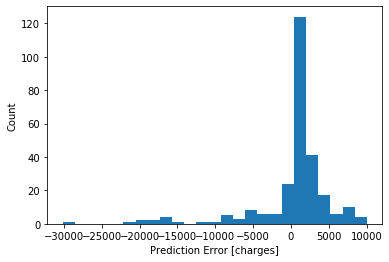

In [25]:
#cheaing the eror distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [charges]')
_ = plt.ylabel('Count')


In [44]:
#dnn_model.save('dnn_model')

2022-03-13 23:22:25.961511: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dnn_model/assets


In [26]:
#reloading the model
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = dnn_model.evaluate(
    test_features, test_labels, verbose=0)

test_results

{'dnn_model': 26841770.0, 'reloaded': 26841770.0}

Note: When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.

The new saved cvs file was to be used in the dashboard file to deploy the interactive dashboard.

In [21]:
#saving the cleaned data into a csv file to be used when creating the dashboard.
data.to_csv('insurance_new.csv')
#df = pd.read_csv('insurance_new.csv')
#df.shape

In [27]:
#clossing the connection with the database
con.commit()
cur.close()
con.close()

## Dashboard with dash

Below, we created a file that was used to deploy an interactive dashboard with our data. The dashboard was build with dash library.

We included a number of componets in the dashboard. We had three dropdowns for the gender(sex) selection, smoking status, and number of children covered. Container texts and a graph of insurance charges verses age for the respective selected groups were added. The scatter points sizes were plotted with respect to the body mass index(bmi). 

The dashboard created is an interactive tool to allow visulization of the relationship between insurance charges and age for the selected group. The group is determined by the parameters selected in the dropdowns.

From the visualization of the data in the dashboard, despite factors like age, bmi or number of children having an influence in the medical charges, the smoking classes have more influence. The non smokers pay less than the smoking patients. 

In [50]:
%%writefile app.py 

# Run this app with `python app.py` and
# visit http://127.0.0.1:8050/ in your web browser.

from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import pandas as pd

app = Dash(__name__)

# importing the data
df = pd.read_csv('insurance_new.csv')
df.shape


# app layout
# App layout
app.layout = html.Div([

    html.H1("Insurance Cost", style={'text-align': 'center'}),

    html.Label('Sex'),
    dcc.Dropdown(id="select_sex",
                 options=[
                     {"label": "female", "value": "female"},
                     {"label": "male", "value": "male"}],
                 multi=False,
                 value="female",
                 style={'width': "40%"}
                 ),
    html.Div(id='output_container1', children=[]),
    html.Br(),

    html.Label('Smoker'),
    dcc.Dropdown(id="select_smoker",
                 options=[
                     {"label": "no", "value": "no"},
                     {"label": "yes", "value": "yes"}],
                 multi=False,
                 value="no",
                 style={'width': "40%"}
                 ),

    html.Div(id='output_container2', children=[]),
    html.Br(),
    
    html.Label('No_Children'),
    dcc.Dropdown(id="select_children",
                 options=[
                     {"label": "0", "value": 0},
                     {"label": "1", "value": 1},
                     {"label": "2", "value": 2},
                     {"label": "3", "value": 3},
                     {"label": "4", "value": 4},
                     {"label": "5", "value": 5}],
                 multi=False,
                 value=0,
                 style={'width': "40%"}
                 ),


    html.Div(id='output_container3', children=[]),
    html.Br(),

    dcc.Graph(id='insurance_graph', figure={})

])


# Connect the Plotly graphs with Dash Components
@app.callback(
    [Output(component_id='output_container1', component_property='children'),
     Output(component_id='output_container2', component_property='children'),
     Output(component_id='output_container3', component_property='children'),
     Output(component_id='insurance_graph', component_property='figure')],
    [Input(component_id='select_sex', component_property='value'),
     Input(component_id='select_smoker', component_property='value'),
     Input(component_id='select_children', component_property='value')]
)
def update_graph(option_slctd,smoker_selected, children_selected):
    
    container1 = "The gender chosen by user was: {}".format(option_slctd)
    container2 = "The smoking status chosen by user was: {}".format(smoker_selected)
    container3 = "The number of chilren chosen by user was: {}".format(children_selected)
    

    dff = df.copy()
    dff = dff[dff["sex"] == option_slctd]
    dff = dff[dff["smoker"] == smoker_selected]
    dff = dff[dff["children"] == children_selected]

   
    

    fig = px.scatter(dff, x="age", y="charges",
                size="bmi", color="region")
    
   
    return container1,container2, container3, fig


if __name__ == '__main__':
    app.run_server(debug=True)

Overwriting app.py


### Limitations and Challeges

Due to time constraints, we decided to train the model with all features in the datasets. A detailed visualization of the data was not provided. However, we used the dashboard created to obtain more insightfull information from the data. This approch was greet because, it allows users of the dashboard to gain both conclusive and inspiratinal information on the insurance costs.

In future, we will try to improve the model perfomance and do a detailed data exploratory analysis.